Testing computational limits of MRF

1. try approximate inference algo to speed up computation
2. try naive bayes model

KEEP TRYING THIS
- could we assign cutoff for edges below a threshold of counts to decrease the size of the graph?

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import MarkovNetwork, JunctionTree
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.factors import factor_product
from pgmpy.inference import BeliefPropagation, ApproxInference
import daft
import random
import itertools


In [21]:
object_list = pd.read_excel('C:/Users/karae/github repositories/vrrl/cooccurrence/post_objects.xlsx', header=None)
objects = []

for i in range(len(object_list)):
    
    objects.append(object_list.iloc[i][0][6:])

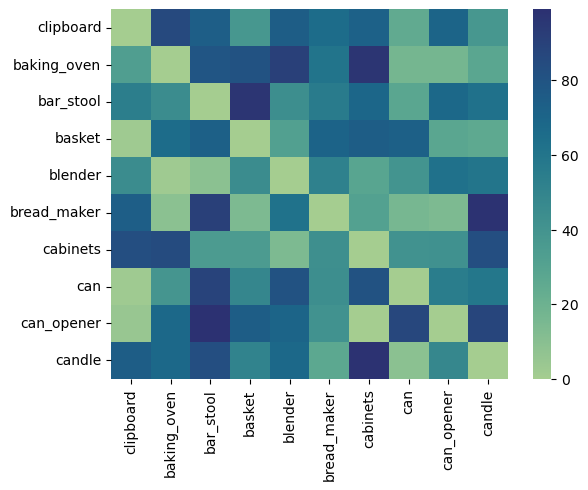

In [22]:
# counts
n = 10
cooccur = np.random.randint(low=0,high=100,size=(n,n))
np.fill_diagonal(cooccur,0)
objects = objects[0:cooccur.shape[0]]

sns.heatmap(cooccur,xticklabels=objects,yticklabels=objects,cmap='crest')

cooccur = pd.DataFrame(cooccur,index=objects,columns=objects)

In [23]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = objects
edges = list(itertools.combinations(objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [24]:
# phi 
def compatibility(edge):
    
    tt = cooccur.loc[edge[0],edge[1]] / np.sum(cooccur.loc[edge[0],:])
    ft = (np.sum(cooccur.loc[:,edge[1]])-cooccur.loc[edge[0],edge[1]]) / (np.sum(np.triu(np.asarray(cooccur)))-np.sum(cooccur.loc[edge[0],:]))
    tf = 1 - tt
    ff = 1 - ft

    phi = [ff, ft, tf, tt]
    
    return phi

In [25]:
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
G = MarkovNetwork()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
phi = [DiscreteFactor(edge, [2, 2], np.random.rand(4)) for edge in G.edges()]
G.add_factors(*phi)
G_infer = BeliefPropagation(G)